# Use IRS Migration Dataset to Detect County Level Migration
**Contents:**
* [Netflow by County, 2011-2020](#county)
* [Net Income Changes Affected by County](#countyincome)
* [Total Changes from 2011 - 2020](#total)
* [What disaster frequency or what disaster level affected migrants' desicion?](#disaster)

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind

In [3]:
data_path = r"F:/IRS_Migration/"
SHELDUS = pd.read_csv("F:/SHELDUS/ORIGINAL.csv")
state    = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/usstate/cb_2018_us_state_500k.shp").to_crs('ESRI:102003')
county  = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/maincounty/us_conu_county.shp").to_crs('ESRI:102003')

In [4]:
state = state[~state["NAME"].isin(["Alaska","Hawaii","Puerto Rico","American Samoa","United States Virgin Islands","Guam","Commonwealth of the Northern Mariana Islands"])]

### 1990-2010 Data can be derived from this link:
https://osf.io/wgcf3/?view_only=c5ba62fb4821421ea0621bfd0d723e61

### Define the inflow, outflow, and format them

In [5]:
def df_flow(year):
    mig_path = str(year)
    df_outflow = pd.read_csv(data_path+f"{mig_path}migrationdata/"+f"countyoutflow{str(year)}.csv", encoding='latin-1')
    df_inflow  = pd.read_csv(data_path+f"{mig_path}migrationdata/"+f"countyinflow{str(year)}.csv", encoding='latin-1')
    df_outflow = df_outflow[(df_outflow["y1_statefips"]<=56) & (df_outflow["y2_statefips"]<=56)].reset_index(drop=True)
    df_inflow  = df_inflow[(df_inflow["y1_statefips"]<=56) & (df_inflow["y2_statefips"]<=56)].reset_index(drop=True)
    df_outflow["y1_statefips"] = df_outflow["y1_statefips"].astype('int64').astype('str').str.rjust(2, "0")
    df_outflow["y1_countyfips"] = df_outflow["y1_countyfips"].astype('int64').astype('str').str.rjust(3, "0")
    df_outflow["y2_statefips"] = df_outflow["y2_statefips"].astype('int64').astype('str').str.rjust(2, "0")
    df_outflow["y2_countyfips"] = df_outflow["y2_countyfips"].astype('int64').astype('str').str.rjust(3, "0")
    df_outflow["y1_FIPS"] = df_outflow["y1_statefips"] + df_outflow["y1_countyfips"]
    df_outflow["y2_FIPS"] = df_outflow["y2_statefips"] + df_outflow["y2_countyfips"]
    df_inflow["y1_statefips"] = df_inflow["y1_statefips"].astype('int64').astype('str').str.rjust(2, "0")
    df_inflow["y1_countyfips"] = df_inflow["y1_countyfips"].astype('int64').astype('str').str.rjust(3, "0")
    df_inflow["y2_statefips"] = df_inflow["y2_statefips"].astype('int64').astype('str').str.rjust(2, "0")
    df_inflow["y2_countyfips"] = df_inflow["y2_countyfips"].astype('int64').astype('str').str.rjust(3, "0")
    df_inflow["y1_FIPS"] = df_inflow["y1_statefips"] + df_inflow["y1_countyfips"]
    df_inflow["y2_FIPS"] = df_inflow["y2_statefips"] + df_inflow["y2_countyfips"]
    df_outflow = df_outflow.rename(columns={"y1_FIPS":f"y1_FIPS{mig_path}","y2_FIPS":f"y2_FIPS{mig_path}","n1":f"n1{mig_path}","n2":f"n2{mig_path}","agi":f"agi{mig_path}"})
    df_inflow  = df_inflow.rename(columns={"y1_FIPS":f"y1_FIPS{mig_path}","y2_FIPS":f"y2_FIPS{mig_path}","n1":f"n1{mig_path}","n2":f"n2{mig_path}","agi":f"agi{mig_path}"})
    return df_outflow,df_inflow

### Select the movement people

In [6]:
def nonormig(df,outorin,year):
    year = str(year)
    if str(outorin) == "out":
        column = "y1_FIPS"+year
    else:
        column = "y2_FIPS"+year
    df_non = df[df["y1_FIPS"+year]==df["y2_FIPS"+year]]
    df_mig = df[df["y1_FIPS"+year]!=df["y2_FIPS"+year]]
    df_mig_group = df_mig.groupby([column]).agg({f"n1{year}":"sum",f"n2{year}":"sum",f"agi{year}":"sum"}).reset_index()
    return df_mig_group

### Netflow = Inflow - Outflow

In [7]:
def net_flow(df_out,df_in,year):
    year = str(year)
    netflow = pd.merge(df_out,df_in,left_on=f"y1_FIPS{year}",right_on=f"y2_FIPS{year}",how="inner")
    netflow[f"net_pop{year}"] = netflow[f"n2{year}_y"] - netflow[f"n2{year}_x"]
    netflow[f"net_income{year}"] = netflow[f"agi{year}_y"] - netflow[f"agi{year}_x"]
    netflow[f"net_pop_per1000_{year}"] = netflow[f"net_income{year}"]/1000
    netflow = pd.merge(netflow,county,left_on=f"y1_FIPS{year}",right_on="FIPS",how="inner")
    netflow_gdf = gpd.GeoDataFrame(netflow,geometry="geometry")
    return netflow_gdf

In [8]:
outflow_1112,inflow_1112 = df_flow("1112")
outflow_1213,inflow_1213 = df_flow("1213")
outflow_1314,inflow_1314 = df_flow("1314")
outflow_1415,inflow_1415 = df_flow("1415")
outflow_1516,inflow_1516 = df_flow("1516")
outflow_1617,inflow_1617 = df_flow("1617")
outflow_1718,inflow_1718 = df_flow("1718")
outflow_1819,inflow_1819 = df_flow("1819")
outflow_1920,inflow_1920 = df_flow("1920")
outflow_2021,inflow_2021 = df_flow("2021")

In [9]:
outflow_1112_mig = nonormig(outflow_1112,"out","1112")
inflow_1112_mig = nonormig(inflow_1112,"in","1112")
outflow_1213_mig = nonormig(outflow_1213,"out","1213")
inflow_1213_mig = nonormig(inflow_1213,"in","1213")
outflow_1314_mig = nonormig(outflow_1314,"out","1314")
inflow_1314_mig = nonormig(inflow_1314,"in","1314")
outflow_1415_mig = nonormig(outflow_1415,"out","1415")
inflow_1415_mig = nonormig(inflow_1415,"in","1415")
outflow_1516_mig = nonormig(outflow_1516,"out","1516")
inflow_1516_mig = nonormig(inflow_1516,"in","1516")
outflow_1617_mig = nonormig(outflow_1617,"out","1617")
inflow_1617_mig = nonormig(inflow_1617,"in","1617")
outflow_1718_mig = nonormig(outflow_1718,"out","1718")
inflow_1718_mig = nonormig(inflow_1718,"in","1718")
outflow_1819_mig = nonormig(outflow_1819,"out","1819")
inflow_1819_mig = nonormig(inflow_1819,"in","1819")
outflow_1920_mig = nonormig(outflow_1920,"out","1920")
inflow_1920_mig = nonormig(inflow_1920,"in","1920")
outflow_2021_mig = nonormig(outflow_2021,"out","2021")
inflow_2021_mig = nonormig(inflow_2021,"in","2021")

In [10]:
netflow_1112 = net_flow(outflow_1112_mig,inflow_1112_mig,"1112")
netflow_1213 = net_flow(outflow_1213_mig,inflow_1213_mig,"1213")
netflow_1314 = net_flow(outflow_1314_mig,inflow_1314_mig,"1314")
netflow_1415 = net_flow(outflow_1415_mig,inflow_1415_mig,"1415")
netflow_1516 = net_flow(outflow_1516_mig,inflow_1516_mig,"1516")
netflow_1617 = net_flow(outflow_1617_mig,inflow_1617_mig,"1617")
netflow_1718 = net_flow(outflow_1718_mig,inflow_1718_mig,"1718")
netflow_1819 = net_flow(outflow_1819_mig,inflow_1819_mig,"1819")
netflow_1920 = net_flow(outflow_1920_mig,inflow_1920_mig,"1920")
netflow_2021 = net_flow(outflow_2021_mig,inflow_2021_mig,"2021")

### Merge 2011 - 2020 Data into one dataframe

In [36]:
year_list = ["1213","1314","1415","1516","1617","1718","1819","1920","2021"]
i = 0
netflow_1213_use = netflow_1213[["y1_FIPS1213","net_pop1213","net_income1213"]]
merged_df = pd.merge(netflow_1112,netflow_1213,left_on="y1_FIPS1112",right_on="y1_FIPS1213",how="inner")
for df in [netflow_1314,netflow_1415,netflow_1516,netflow_1617,netflow_1718,netflow_1819,netflow_1920,netflow_2021]:
    year = year_list[i]
    year2 = year_list[i+1]
    df_used = df[[f"y1_FIPS{year2}",f"net_pop{year2}",f"net_income{year2}"]]
    merged_df = pd.merge(merged_df,df_used,left_on=f"y1_FIPS{year}",right_on=f"y1_FIPS{year2}",how="inner")
    i = i + 1

In [38]:
mig_11_20 = merged_df.rename(columns={
            "y1_FIPS1112":"outflow_origin",
            "net_pop1112":"2011","net_income1112":"2011i","net_pop1718":"2017","net_income1718":"2017i",
            "net_pop1213":"2012","net_income1213":"2012i","net_pop1819":"2018","net_income1819":"2018i",
            "net_pop1314":"2013","net_income1314":"2013i","net_pop1920":"2019","net_income1920":"2019i",
            "net_pop1415":"2014","net_income1415":"2014i","net_pop2021":"2020","net_income2021":"2020i",
            "net_pop1516":"2015","net_income1516":"2015i",
            "net_pop1617":"2016","net_income1617":"2016i"
})
mig_11_20 = mig_11_20[["outflow_origin","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020",
                       "2011i","2012i","2013i","2014i","2015i","2016i","2017i","2018i","2019i","2020i"]]

In [114]:
def format_fips(fips):
    return str(fips)[0:2]
mig_11_20["state"] = mig_11_20["outflow_origin"].apply(format_fips)

## Netflow by County, 2011 - 2020 <a class="anchor" id="county"></a>

C:\Users\xiang11\AppData\Local\Temp\ipykernel_24616\3805633318.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


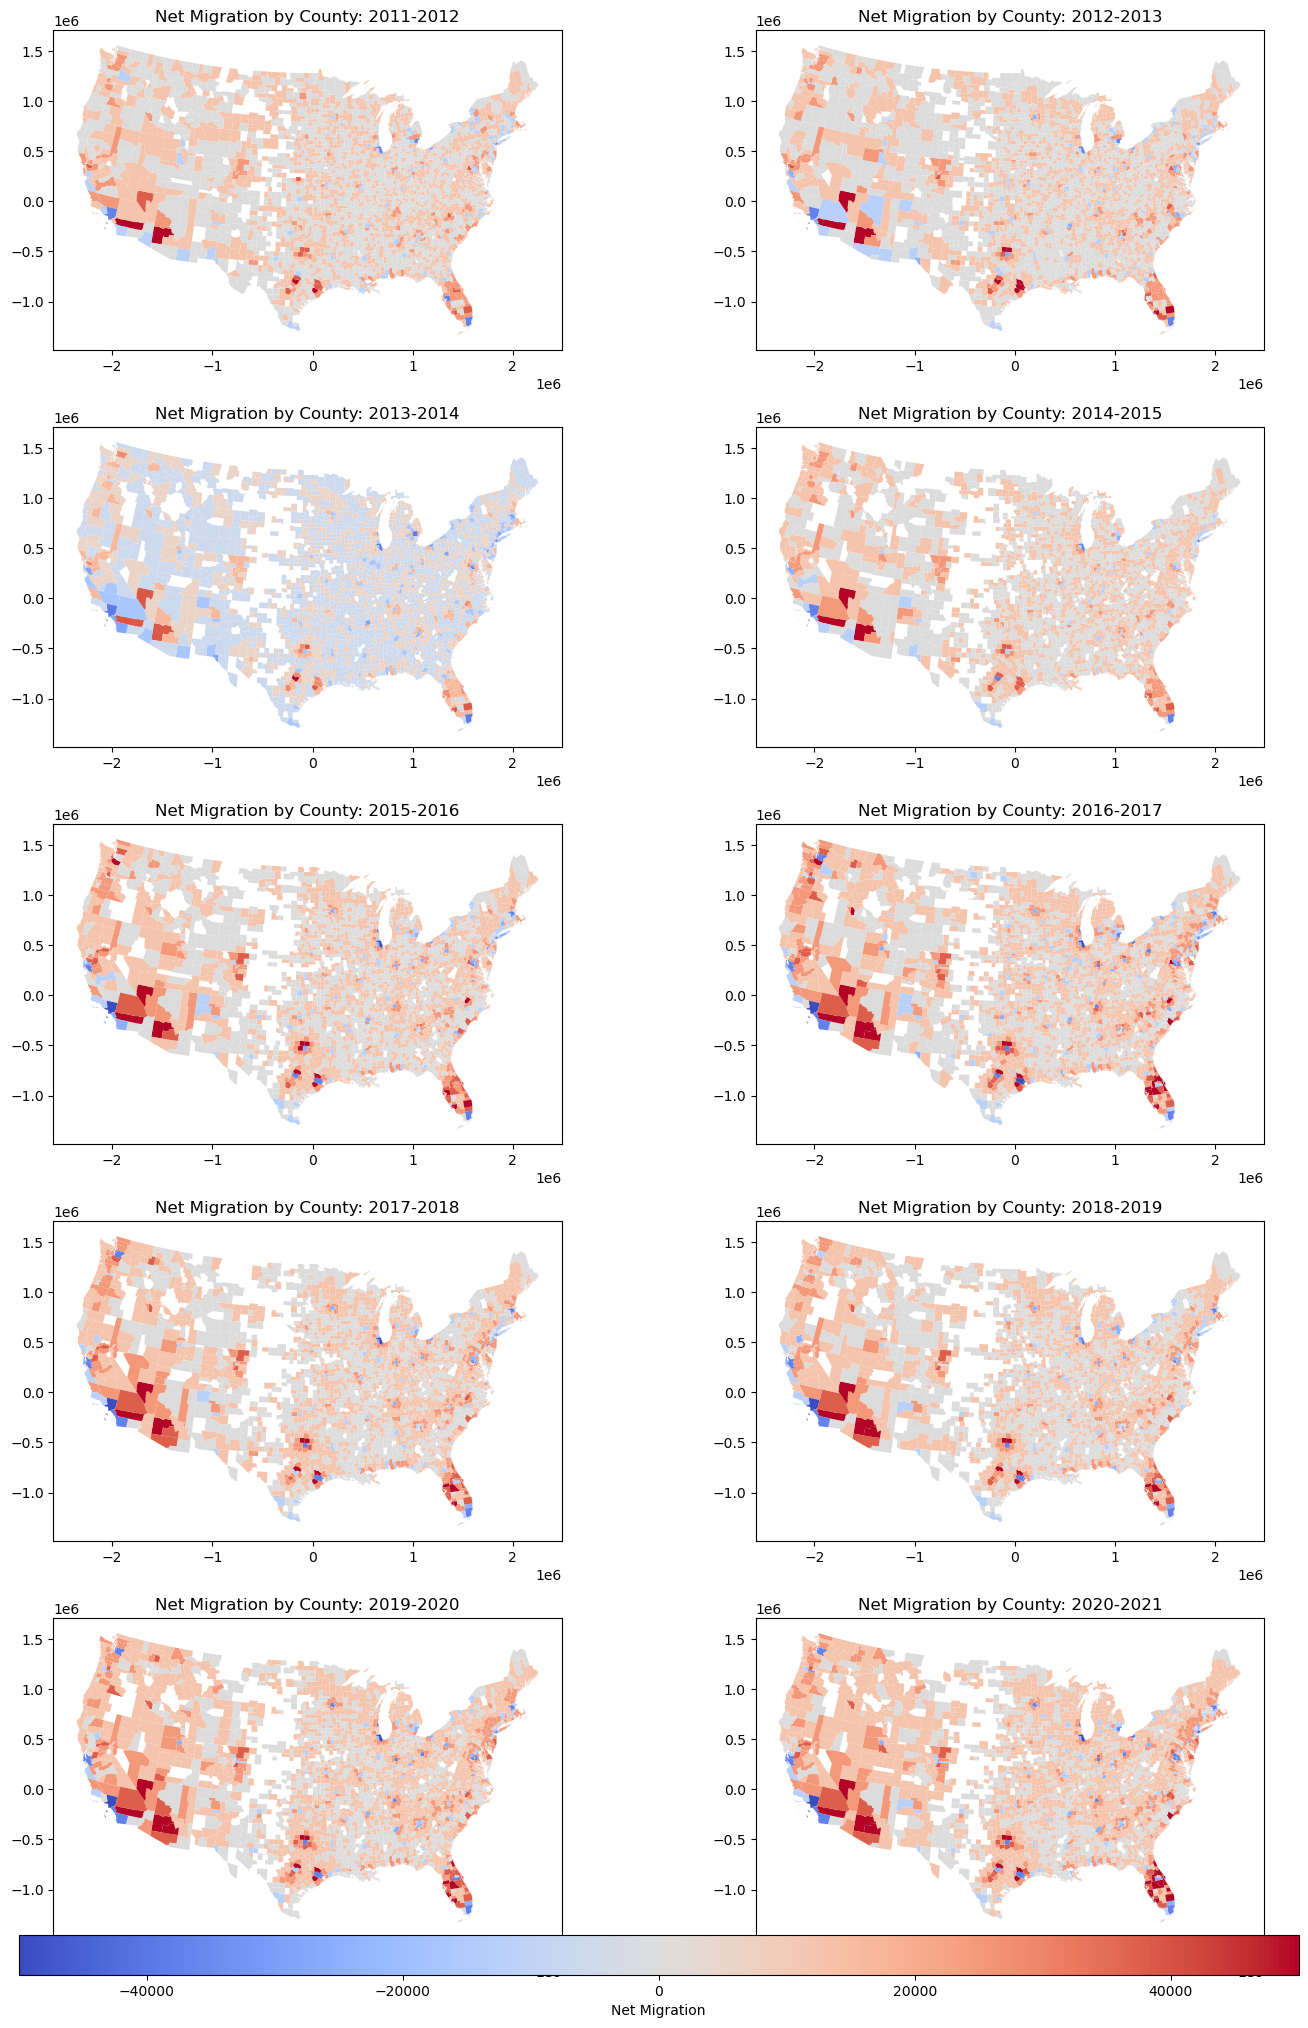

In [11]:
fig, axes = plt.subplots(5,2, figsize=(16, 20))
netflow_1112.plot(column="net_pop1112",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[0,0])
axes[0,0].set_title('Net Migration by County: 2011-2012')
netflow_1213.plot(column="net_pop1213",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[0,1])
axes[0,1].set_title('Net Migration by County: 2012-2013')
netflow_1314.plot(column="net_pop1314",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[1,0])
axes[1,0].set_title('Net Migration by County: 2013-2014')
netflow_1415.plot(column="net_pop1415",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[1,1])
axes[1,1].set_title('Net Migration by County: 2014-2015')
netflow_1516.plot(column="net_pop1516",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[2,0])
axes[2,0].set_title('Net Migration by County: 2015-2016')
netflow_1617.plot(column="net_pop1617",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[2,1])
axes[2,1].set_title('Net Migration by County: 2016-2017')
netflow_1718.plot(column="net_pop1718",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[3,0])
axes[3,0].set_title('Net Migration by County: 2017-2018')
netflow_1819.plot(column="net_pop1819",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[3,1])
axes[3,1].set_title('Net Migration by County: 2018-2019')
netflow_1920.plot(column="net_pop1920",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[4,0])
axes[4,0].set_title('Net Migration by County: 2019-2020')
netflow_2021.plot(column="net_pop2021",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-50000,-10000,-5000,-1000,0,1000,5000,10000,50000]},
                  ax = axes[4,1])
axes[4,1].set_title('Net Migration by County: 2020-2021')

cax = fig.add_axes([0.1, 0.01, 0.8, 0.02])  # Position of the legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-50000, vmax=50000))
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Net Migration')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.3)
plt.tight_layout()

### Mark: Potential anomoly in 2013-2014

## Net Income Changes Affected by County <a class="anchor" id="countyincome"></a>

C:\Users\xiang11\AppData\Local\Temp\ipykernel_30212\1650748880.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


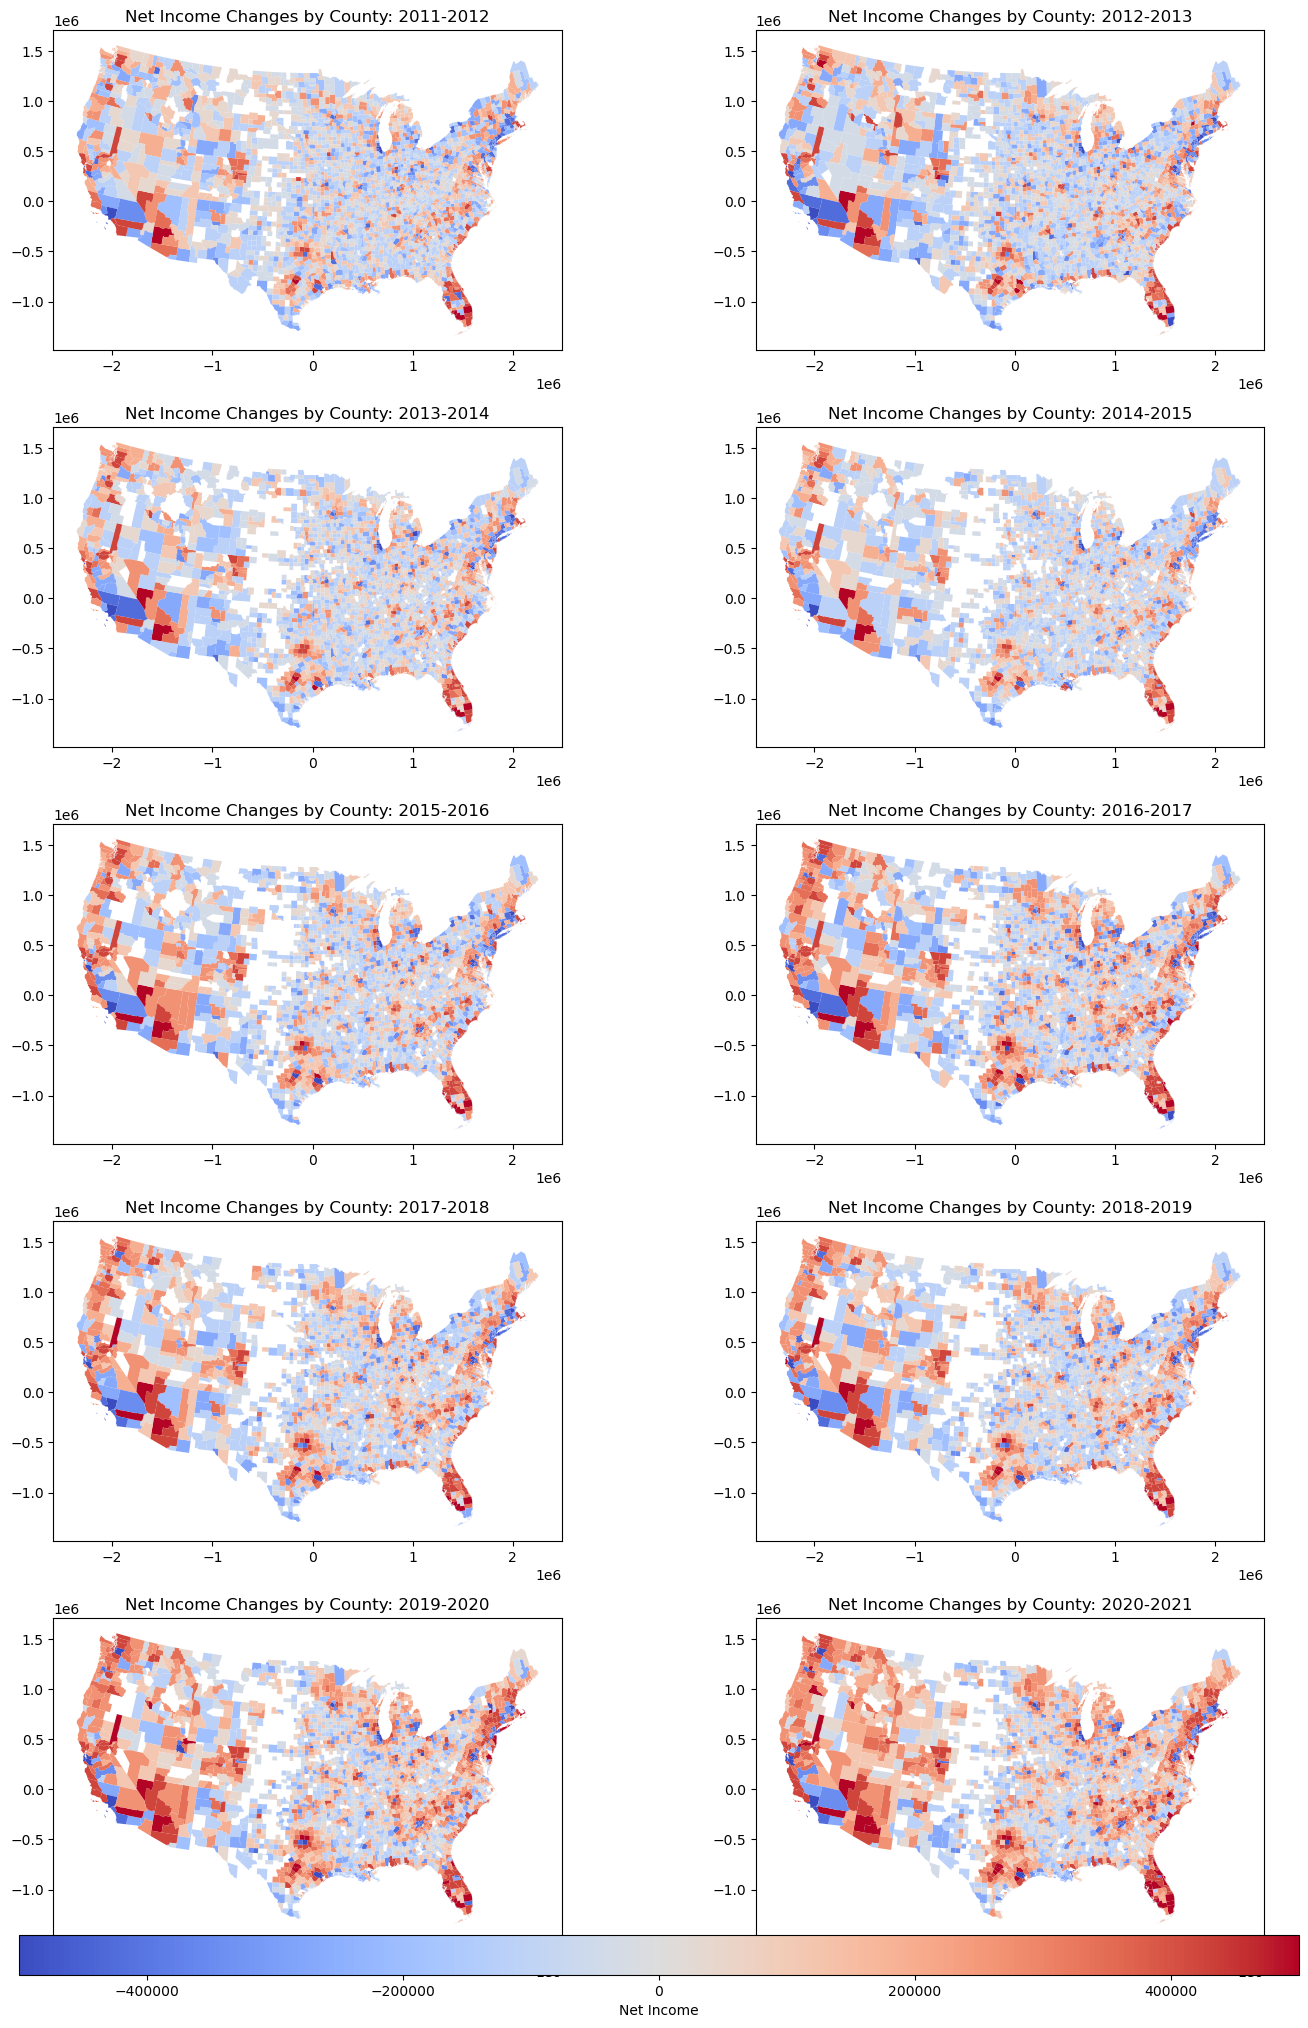

In [299]:
fig, axes = plt.subplots(5,2, figsize=(16, 20))
netflow_1112.plot(column="net_income1112",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[0,0])
axes[0,0].set_title('Net Income Changes by County: 2011-2012')
netflow_1213.plot(column="net_income1213",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[0,1])
axes[0,1].set_title('Net Income Changes by County: 2012-2013')
netflow_1314.plot(column="net_income1314",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[1,0])
axes[1,0].set_title('Net Income Changes by County: 2013-2014')
netflow_1415.plot(column="net_income1415",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[1,1])
axes[1,1].set_title('Net Income Changes by County: 2014-2015')
netflow_1516.plot(column="net_income1516",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[2,0])
axes[2,0].set_title('Net Income Changes by County: 2015-2016')
netflow_1617.plot(column="net_income1617",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[2,1])
axes[2,1].set_title('Net Income Changes by County: 2016-2017')
netflow_1718.plot(column="net_income1718",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[3,0])
axes[3,0].set_title('Net Income Changes by County: 2017-2018')
netflow_1819.plot(column="net_income1819",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[3,1])
axes[3,1].set_title('Net Income Changes by County: 2018-2019')
netflow_1920.plot(column="net_income1920",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[4,0])
axes[4,0].set_title('Net Income Changes by County: 2019-2020')
netflow_2021.plot(column="net_income2021",cmap="coolwarm",
                  scheme='userdefined',classification_kwds={'bins':[-500000,-100000,-50000,-10000,-5000,-1000,0,1000,5000,10000,50000,100000,500000]},
                  ax = axes[4,1])
axes[4,1].set_title('Net Income Changes by County: 2020-2021')

cax = fig.add_axes([0.1, 0.01, 0.8, 0.02])  # Position of the legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-500000, vmax=500000))
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Net Income')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.3)
plt.tight_layout()

In [144]:
year_list = ["1213","1314","1415","1516","1617","1718","1819","1920","2021"]
i = 0
netflow_1213_use = netflow_1213[["y1_FIPS1213","net_pop1213","net_income1213"]]
merged_df = pd.merge(netflow_1112,netflow_1213,left_on="y1_FIPS1112",right_on="y1_FIPS1213",how="inner")
for df in [netflow_1314,netflow_1415,netflow_1516,netflow_1617,netflow_1718,netflow_1819,netflow_1920,netflow_2021]:
    year = year_list[i]
    year2 = year_list[i+1]
    df_used = df[[f"y1_FIPS{year2}",f"net_pop{year2}",f"net_income{year2}"]]
    merged_df = pd.merge(merged_df,df_used,left_on=f"y1_FIPS{year}",right_on=f"y1_FIPS{year2}",how="inner")
    i = i + 1

In [149]:
merged_df["net_pop_1121"] = merged_df["net_pop1112"] + merged_df["net_pop1213"] + merged_df["net_pop1314"] + merged_df["net_pop1415"] + merged_df["net_pop1516"] + merged_df["net_pop1617"] + merged_df["net_pop1718"] + merged_df["net_pop1819"] + merged_df["net_pop1920"] + merged_df["net_pop2021"]
merged_df["net_income_1121"] =  merged_df["net_income1112"] + merged_df["net_income1213"] + merged_df["net_income1314"] + merged_df["net_income1415"] +  merged_df["net_income1516"] + merged_df["net_income1617"] + merged_df["net_income1718"] + merged_df["net_income1819"] + merged_df["net_income1920"] + merged_df["net_income2021"]

In [151]:
merged_gdf = pd.merge(merged_df,county,left_on="y1_FIPS1112",right_on="FIPS",how="inner")
merged_gdf = gpd.GeoDataFrame(merged_gdf,geometry="geometry")

## Total Changes from 2011 - 2020 <a class="anchor" id="total"></a>

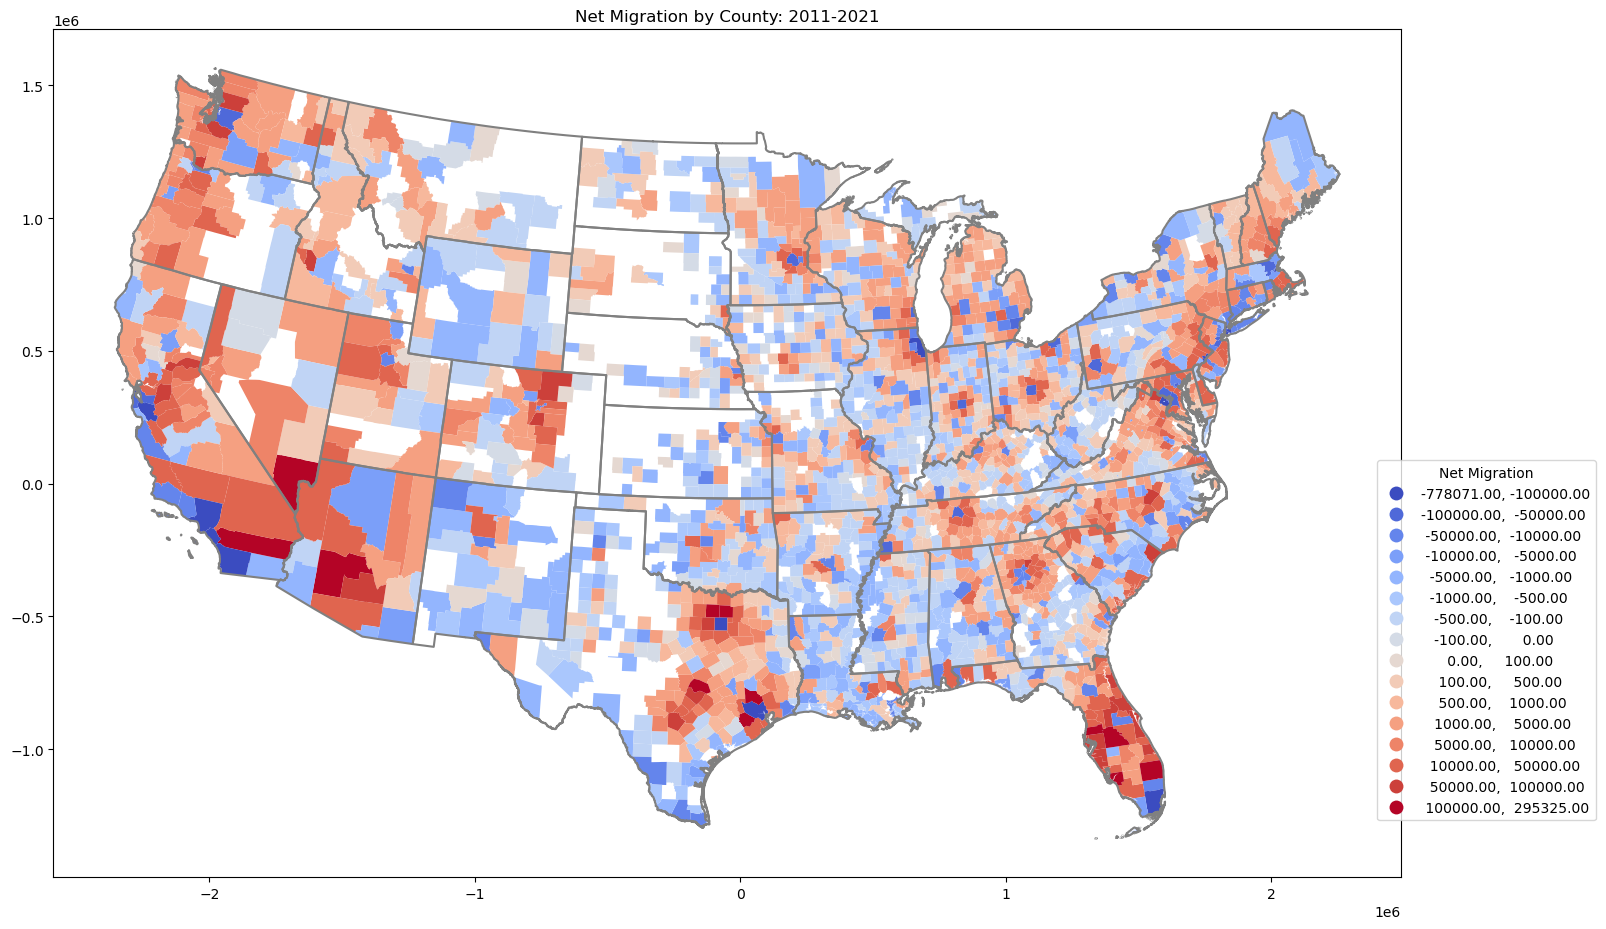

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

state.boundary.plot(ax=ax,color="grey")
merged_gdf.plot(column="net_pop_1121", cmap="coolwarm", scheme="userdefined",
                classification_kwds={'bins': [-100000, -50000, -10000, -5000, -1000, -500, -100, 0, 100, 500, 1000, 5000, 10000, 50000, 100000]},
                legend=True, ax=ax)

ax.set_title("Net Migration by County: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Migration")

plt.tight_layout()
plt.show()

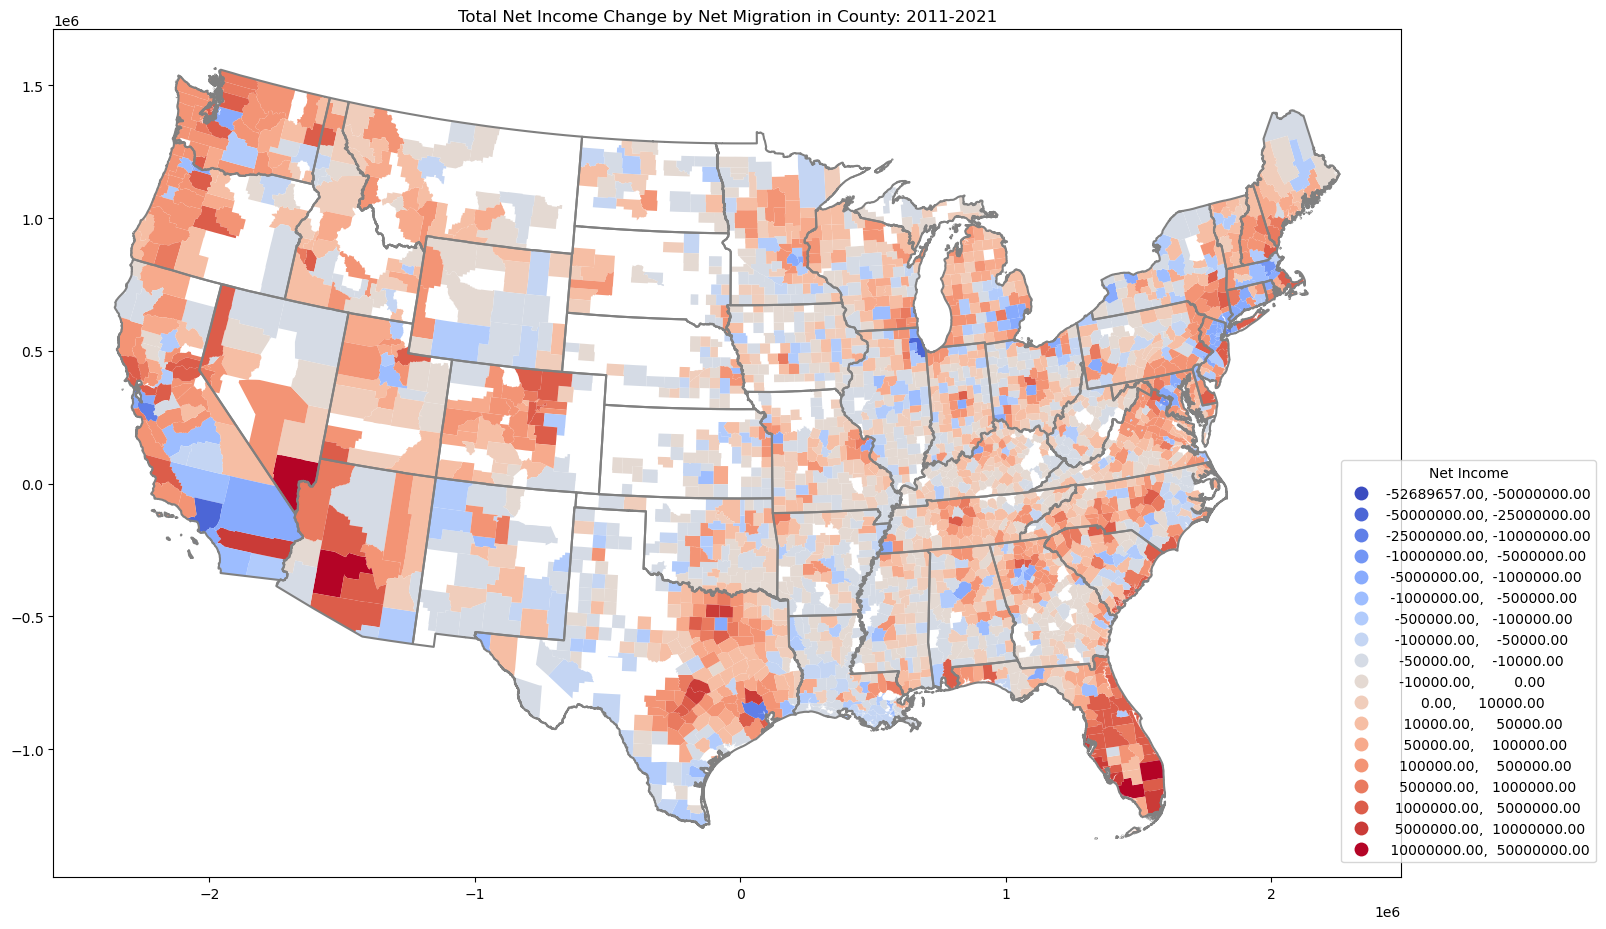

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

state.boundary.plot(ax=ax,color="grey")
merged_gdf.plot(column="net_income_1121", cmap="coolwarm", 
#                 scheme="quantiles",
                scheme="userdefined",
                classification_kwds={'bins': [-50000000,-25000000,-10000000,-5000000,-1000000,-500000,-100000,-50000,-10000,0,10000,50000,100000,500000,1000000,5000000,10000000,50000000]},
                legend=True, ax=ax)
ax.set_title("Total Net Income Change by Net Migration in County: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Income")

plt.tight_layout()
plt.show()

### 

### Mark: Some areas experience net outflow but with the total gross income increasing.
Miami, some cities in CA

In [221]:
merged_gdf_top50 = merged_gdf.sort_values(by="net_pop_1121",ascending=False)
merged_gdf_top50 = merged_gdf_top50[0:50].reset_index(drop=True)
merged_gdf_bot50 = merged_gdf.sort_values(by="net_pop_1121",ascending=True)
merged_gdf_bot50 = merged_gdf_bot50[0:50].reset_index(drop=True)

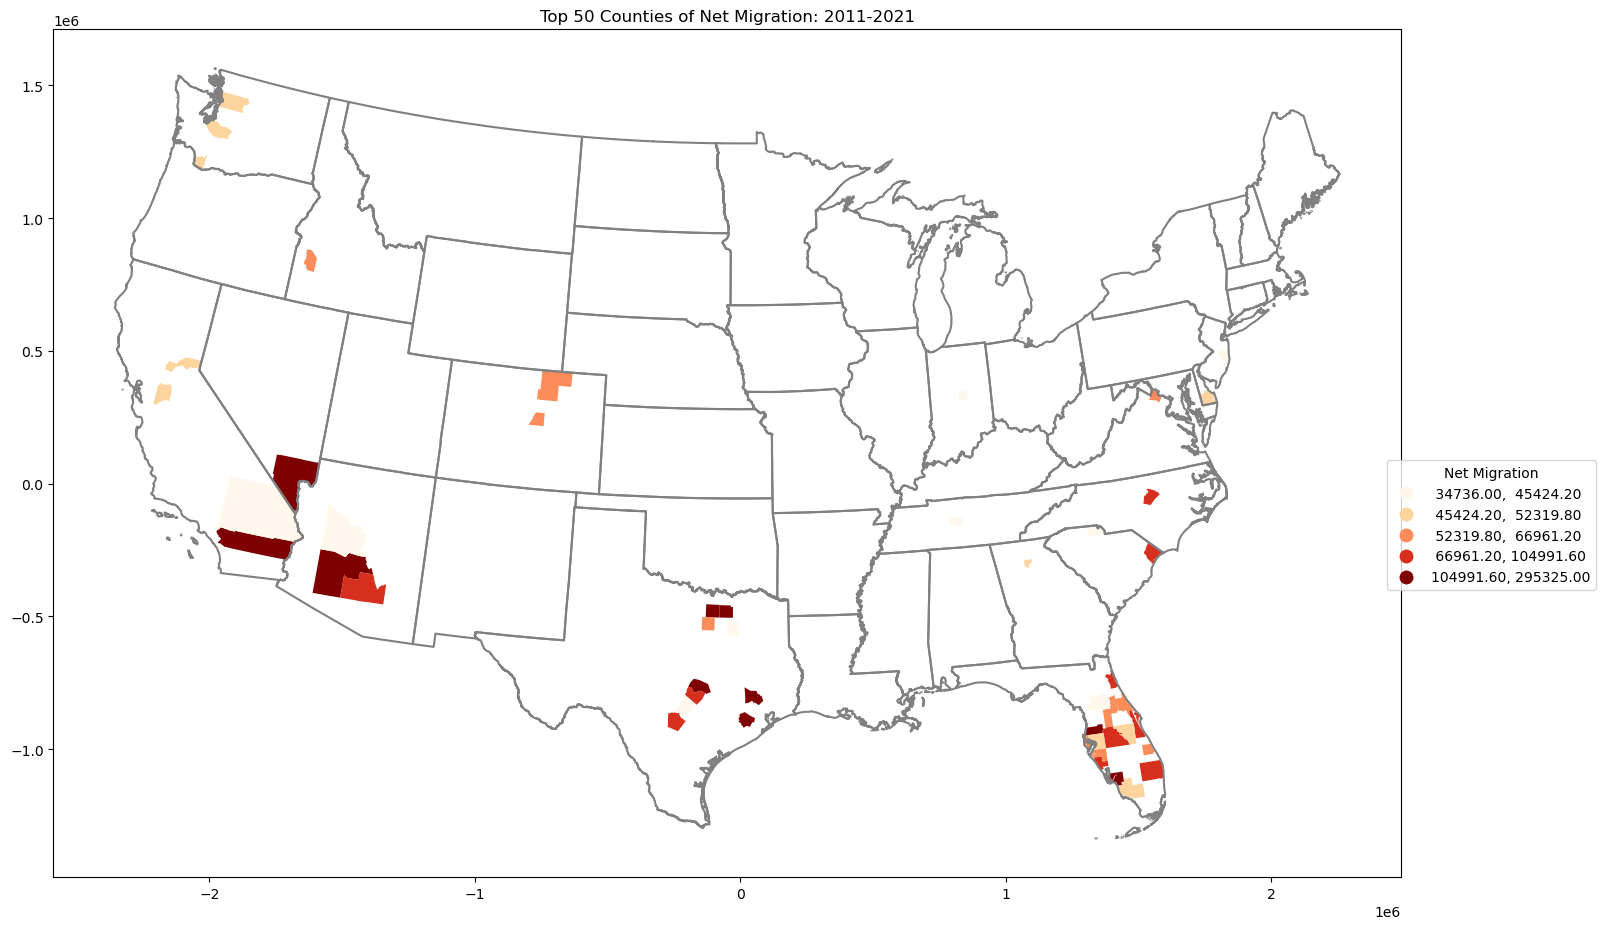

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

state.boundary.plot(ax=ax,color="grey")
merged_gdf_top50.plot(column="net_pop_1121", cmap="OrRd",
                      scheme = "quantiles",
#                       scheme="userdefined",
#                 classification_kwds={'bins': [-100000, -50000, -10000, -5000, -1000, -500, -100, 0, 100, 500, 1000, 5000, 10000, 50000, 100000]},
                legend=True, ax=ax)

ax.set_title("Top 50 Counties of Net Migration: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Migration")

plt.tight_layout()
plt.show()

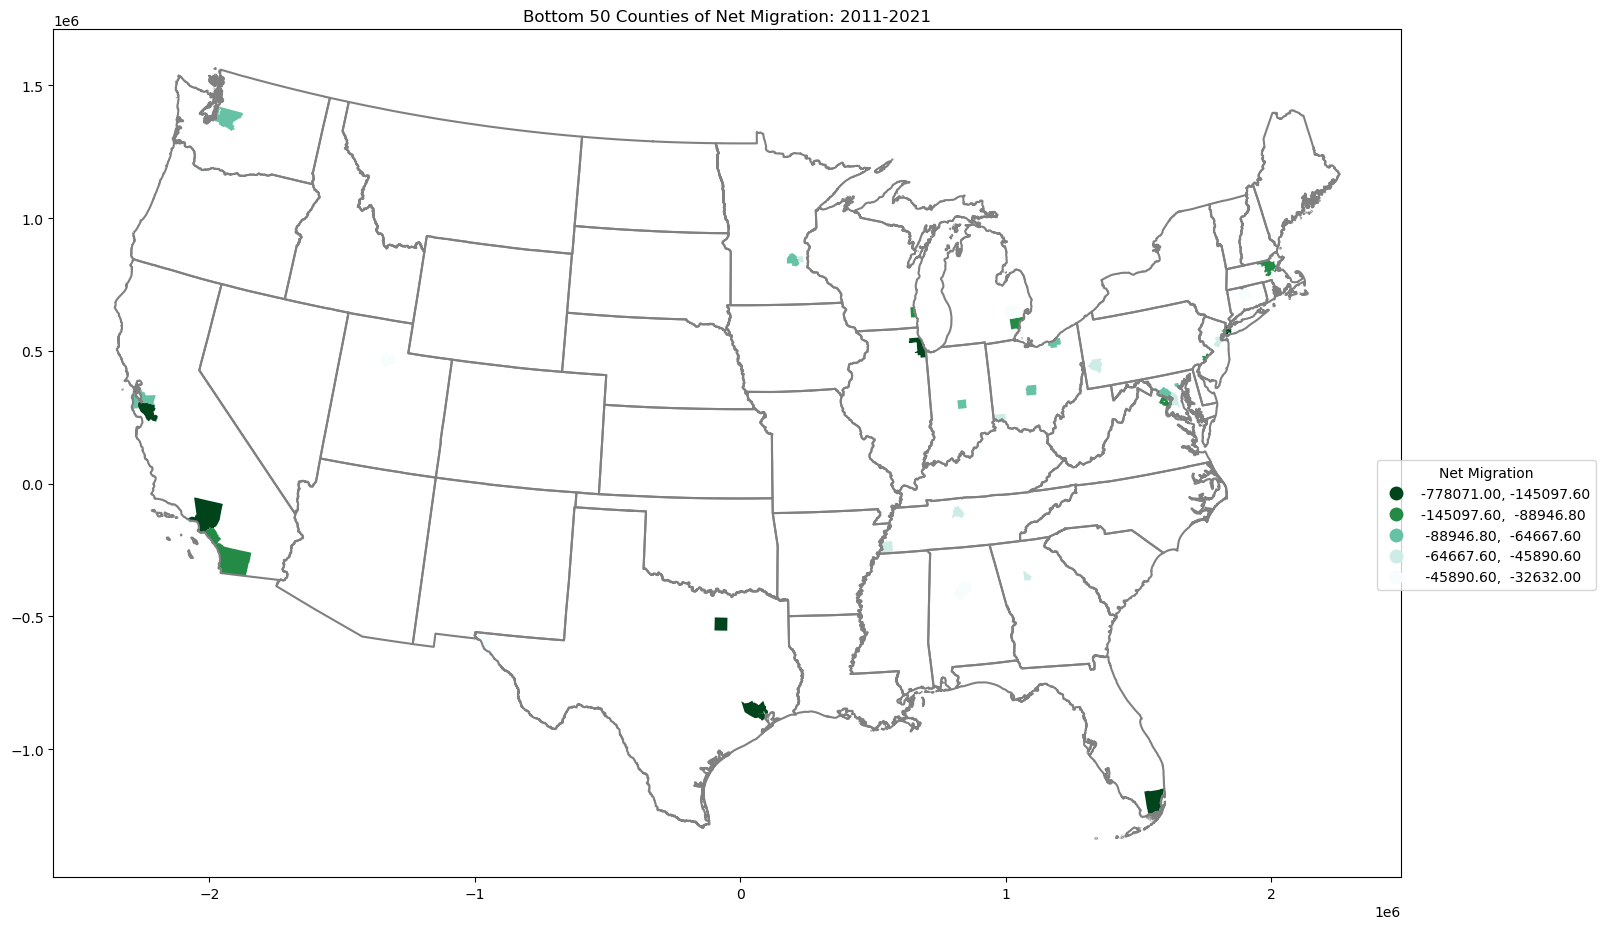

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

state.boundary.plot(ax=ax,color="grey")
merged_gdf_bot50.plot(column="net_pop_1121", cmap="BuGn_r",
                      scheme = "quantiles",
#                       scheme="userdefined",
#                 classification_kwds={'bins': [-100000, -50000, -10000, -5000, -1000, -500, -100, 0, 100, 500, 1000, 5000, 10000, 50000, 100000]},
                legend=True, ax=ax)

ax.set_title("Bottom 50 Counties of Net Migration: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Migration")

plt.tight_layout()
plt.show()

In [232]:
merged_gdf_top50_income = merged_gdf.sort_values(by="net_income_1121",ascending=False)
merged_gdf_top50_income = merged_gdf_top50_income[0:50].reset_index(drop=True)
merged_gdf_bot50_income = merged_gdf.sort_values(by="net_income_1121",ascending=True)
merged_gdf_bot50_income = merged_gdf_bot50_income[0:50].reset_index(drop=True)

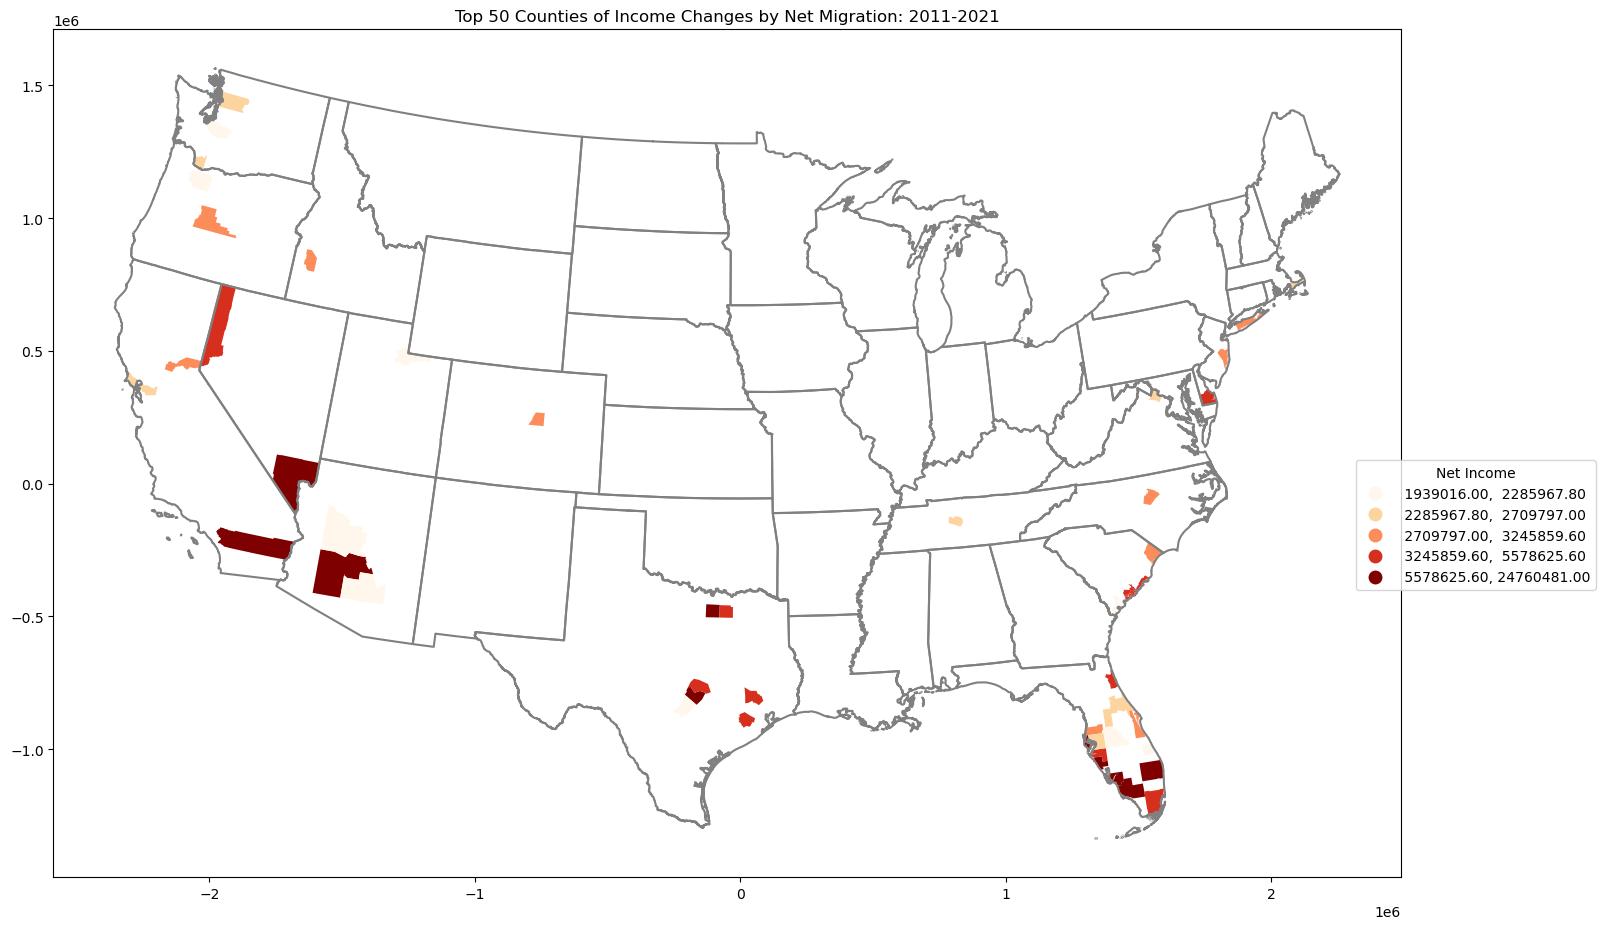

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

state.boundary.plot(ax=ax,color="grey")
merged_gdf_top50_income.plot(column="net_income_1121", cmap="OrRd",
                      scheme = "quantiles",
#                       scheme="userdefined",
#                 classification_kwds={'bins': [-100000, -50000, -10000, -5000, -1000, -500, -100, 0, 100, 500, 1000, 5000, 10000, 50000, 100000]},
                legend=True, ax=ax)

ax.set_title("Top 50 Counties of Income Changes by Net Migration: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Income")

plt.tight_layout()
plt.show()

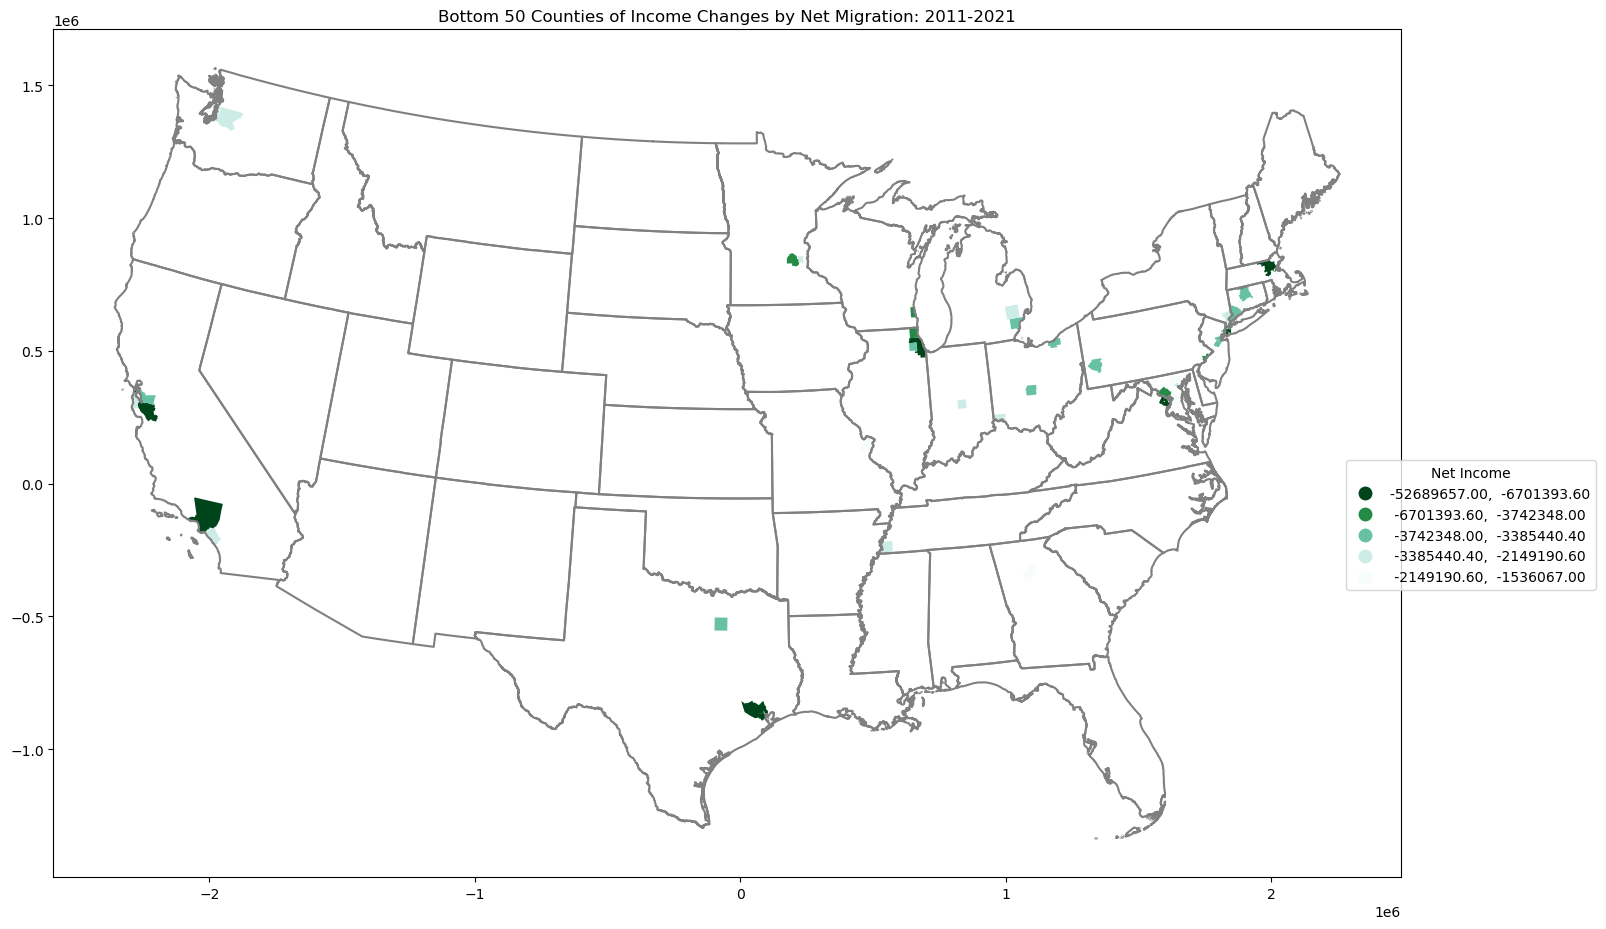

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

state.boundary.plot(ax=ax,color="grey")
merged_gdf_bot50_income.plot(column="net_income_1121", cmap="BuGn_r",
                      scheme = "quantiles",
#                       scheme="userdefined",
#                 classification_kwds={'bins': [-100000, -50000, -10000, -5000, -1000, -500, -100, 0, 100, 500, 1000, 5000, 10000, 50000, 100000]},
                legend=True, ax=ax)

ax.set_title("Bottom 50 Counties of Income Changes by Net Migration: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Income")

plt.tight_layout()
plt.show()

In [200]:
merged_gdf_groupstate = merged_gdf.groupby("STATE_NAME").agg({"net_income_1121":"sum","net_pop_1121":"sum"}).reset_index()
merged_gdf_groupstate = pd.merge(merged_gdf_groupstate,state,left_on="STATE_NAME",right_on="NAME")
merged_gdf_groupstate = gpd.GeoDataFrame(merged_gdf_groupstate,geometry="geometry")

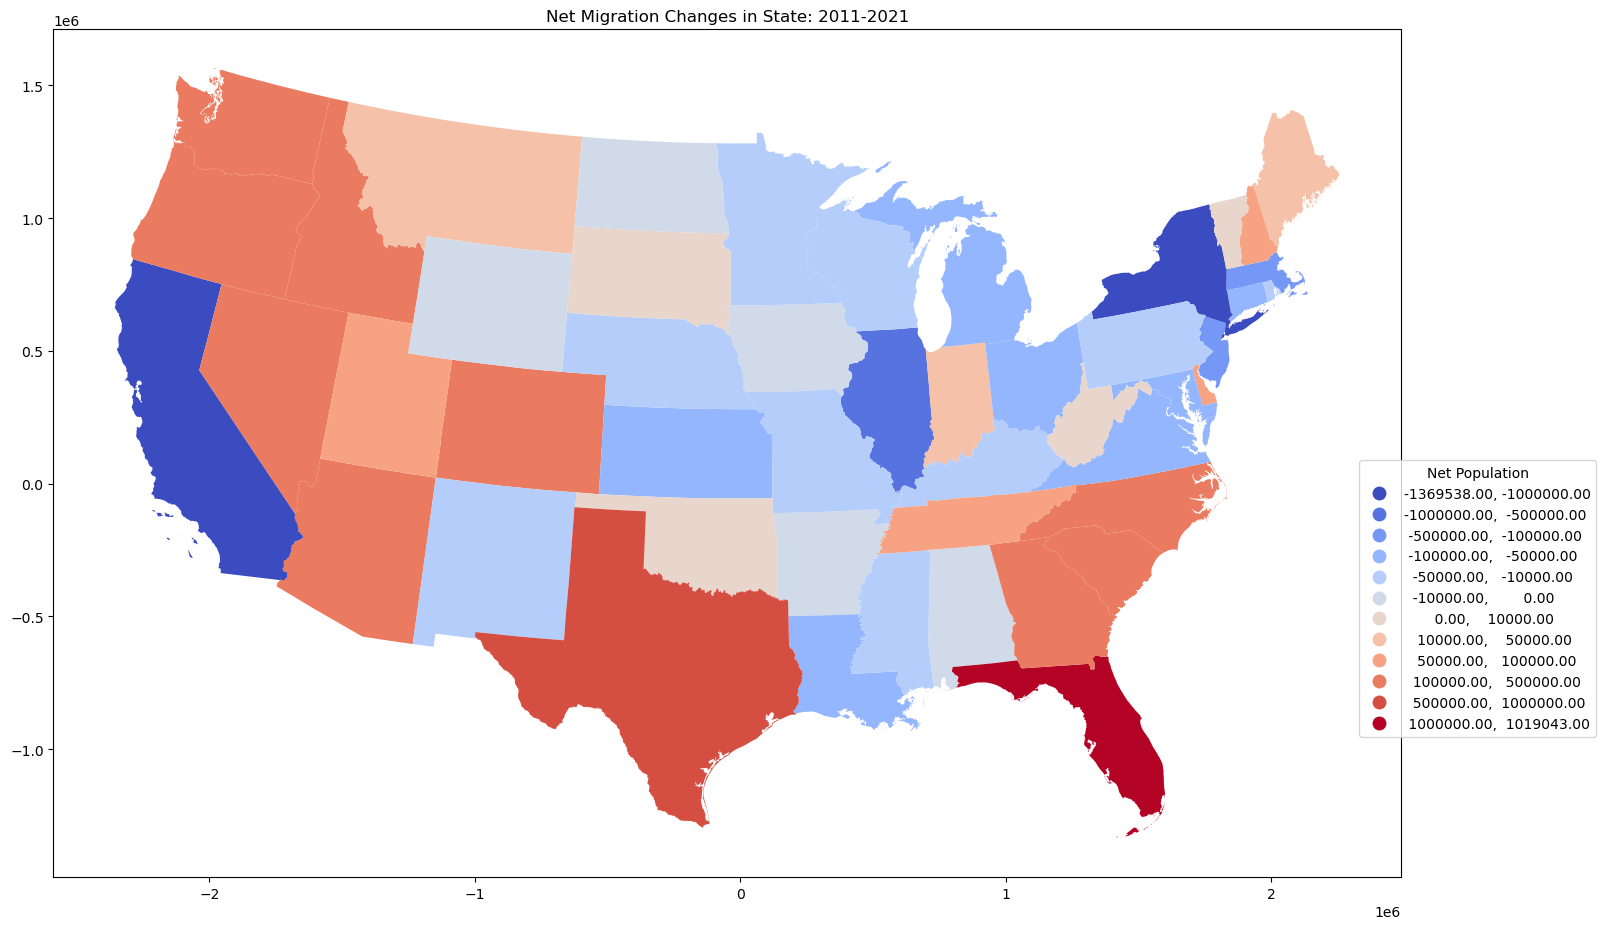

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

# state.boundary.plot(ax=ax,color="grey")
merged_gdf_groupstate.plot(column="net_pop_1121", cmap="coolwarm", 
#                 scheme="quantiles",
                scheme="userdefined",
                classification_kwds={'bins': [-1000000,-500000,-100000,-50000,-10000,0,10000,50000,100000,500000,1000000]},
                legend=True, ax=ax)
ax.set_title("Net Migration Changes in State: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Population")

plt.tight_layout()
plt.show()

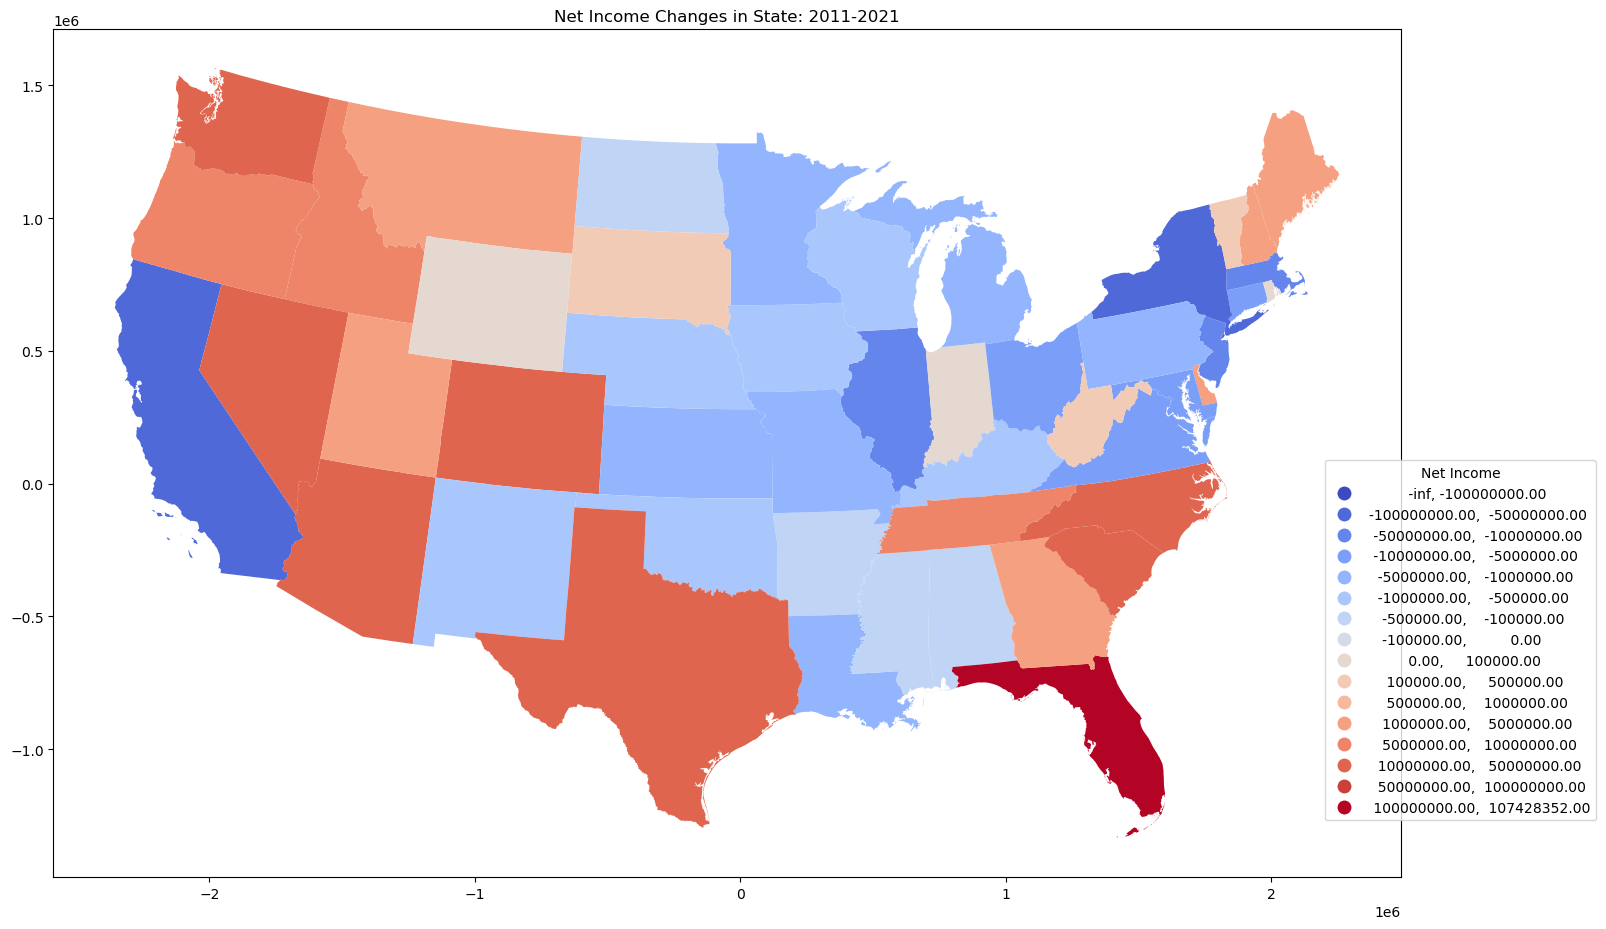

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

# state.boundary.plot(ax=ax,color="grey")
merged_gdf_groupstate.plot(column="net_income_1121", cmap="coolwarm", 
#                 scheme="quantiles",
                scheme="userdefined",
                classification_kwds={'bins': [-100000000,-50000000,-10000000,-5000000,-1000000,-500000,-100000,0,100000,500000,1000000,5000000,10000000,50000000,100000000]},
                legend=True, ax=ax)
ax.set_title("Net Income Changes in State: 2011-2021")
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5)) 
leg.set_title("Net Income")

plt.tight_layout()
plt.show()

In [217]:
year_use_list = []
for i in range(2011,2021):
#     i = str(i)
    year_use_list.append(i)

## What disaster frequency or what disaster level affected migrants' desicion?<a class="anchor" id="disaster"></a>

In [218]:
SHELDUS_1020 = SHELDUS[SHELDUS["Year"].isin(year_use_list)].reset_index()
SHELDUS_1020['County FIPS'] = SHELDUS_1020['County FIPS'].str.replace("'", "")

In [219]:
SHELDUS_1020_flood = SHELDUS_1020[SHELDUS_1020["Hazard"]=="Flooding"].reset_index(drop=True)
SHELDUS_1020_hurricane = SHELDUS_1020[SHELDUS_1020["Hazard"]=="Hurricane/Tropical Storm"].reset_index(drop=True)

In [220]:
SHELDUS_1020_hurricane_total_group = SHELDUS_1020_hurricane.groupby(["County FIPS"]).count().reset_index()
SHELDUS_1020_hurricane_total_group = SHELDUS_1020_hurricane_total_group[["County FIPS","State Name"]]
SHELDUS_1020_hurricane_total_group = SHELDUS_1020_hurricane_total_group.rename(columns={"State Name":"count"})

In [223]:
SHELDUS_1020_hurricane_total_group

County FIPS  count
0         01003      2
1         01013      1
2         01023      1
3         01031      2
4         01039      1
..          ...    ...
715       72141      1
716       72143      1
717       72145      1
718       72149      2
719       72151      1

[720 rows x 2 columns]

In [225]:
mig_11_20["net_11_20"] = mig_11_20["2011"]+mig_11_20["2012"]+mig_11_20["2013"]+mig_11_20["2014"]+mig_11_20["2015"]+mig_11_20["2016"]+mig_11_20["2017"]+mig_11_20["2018"]+mig_11_20["2019"]+mig_11_20["2020"]

In [227]:
mig_11_20_total = mig_11_20[["outflow_origin","net_11_20"]]

In [232]:
total_merge = pd.merge(mig_11_20_total,SHELDUS_1020_hurricane_total_group,left_on="outflow_origin",right_on="County FIPS",how="outer")
total_merge = total_merge.fillna(0)
total_merge = total_merge[total_merge["outflow_origin"]!=0]
total_merge

outflow_origin  net_11_20 County FIPS  count
0             01001     1557.0           0    0.0
1             01003    24490.0       01003    2.0
2             01005    -1209.0           0    0.0
3             01007      462.0           0    0.0
4             01009     2385.0           0    0.0
...             ...        ...         ...    ...
2602          56031     -152.0           0    0.0
2603          56033      778.0           0    0.0
2604          56037    -2695.0           0    0.0
2605          56039    -1344.0           0    0.0
2606          56041     -112.0           0    0.0

[2607 rows x 4 columns]

### T-test between frequency over 4 times in 2011-2020 and less than 4 times

In [248]:
group1_total = total_merge[(total_merge["count"]<4)]["net_11_20"]
group2_total = total_merge[total_merge["count"]>=4]["net_11_20"]
t_stat, p_value = ttest_ind(group1_total, group2_total, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.5993052860145054, P-value: 0.10987405350379874


In [250]:
mig_11_20["net_11_16"] = mig_11_20["2011"]+mig_11_20["2012"]+mig_11_20["2013"]+mig_11_20["2014"]+mig_11_20["2015"]+mig_11_20["2016"]
mig_11_20["net_17_20"] = mig_11_20["2017"]+mig_11_20["2018"]+mig_11_20["2019"]+mig_11_20["2020"]

In [255]:
SHELDUS_1116_hurricane_total_group = SHELDUS_1020_hurricane[SHELDUS_1020_hurricane["Year"]<2017]
SHELDUS_1116_hurricane_total_group = SHELDUS_1116_hurricane_total_group.groupby(["County FIPS"]).count().reset_index()
SHELDUS_1116_hurricane_total_group = SHELDUS_1116_hurricane_total_group[["County FIPS","State Name"]]
SHELDUS_1116_hurricane_total_group = SHELDUS_1116_hurricane_total_group.rename(columns={"State Name":"count"})

In [256]:
SHELDUS_1116_hurricane_total_group

County FIPS  count
0         01099      1
1         05001      1
2         05005      1
3         05009      1
4         05011      1
..          ...    ...
424       72131      1
425       72141      1
426       72143      1
427       72145      1
428       72149      1

[429 rows x 2 columns]

In [251]:
mig_11_16_total = mig_11_20[["outflow_origin","net_11_16"]]
mig_17_20_total = mig_11_20[["outflow_origin","net_17_20"]]
mig_17          = mig_11_20[["outflow_origin","2017"]]

In [258]:
merge_1116 = pd.merge(mig_11_16_total,SHELDUS_1116_hurricane_total_group,left_on="outflow_origin",right_on="County FIPS",how="outer")
merge_1116 = merge_1116.fillna(0)
merge_1116 = merge_1116[merge_1116["outflow_origin"]!=0]
merge_1116

outflow_origin  net_11_16 County FIPS  count
0             01001      523.0           0    0.0
1             01003    12955.0           0    0.0
2             01005     -757.0           0    0.0
3             01007      350.0           0    0.0
4             01009     1305.0           0    0.0
...             ...        ...         ...    ...
2602          56031     -145.0           0    0.0
2603          56033      502.0           0    0.0
2604          56037    -1468.0           0    0.0
2605          56039     -529.0           0    0.0
2606          56041     -457.0           0    0.0

[2607 rows x 4 columns]

In [264]:
group1_1116 = merge_1116[(merge_1116["count"]<1)]["net_11_16"]
group2_1116 = merge_1116[merge_1116["count"]>=1]["net_11_16"]
t_stat, p_value = ttest_ind(group1_1116, group2_1116, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 0.3599916440725838, P-value: 0.7188825648492888


In [265]:
SHELDUS_1720_hurricane_total_group = SHELDUS_1020_hurricane[SHELDUS_1020_hurricane["Year"]>=2017]
SHELDUS_1720_hurricane_total_group = SHELDUS_1720_hurricane_total_group.groupby(["County FIPS"]).count().reset_index()
SHELDUS_1720_hurricane_total_group = SHELDUS_1720_hurricane_total_group[["County FIPS","State Name"]]
SHELDUS_1720_hurricane_total_group = SHELDUS_1720_hurricane_total_group.rename(columns={"State Name":"count"})

In [266]:
SHELDUS_1720_hurricane_total_group

County FIPS  count
0         01003      2
1         01013      1
2         01023      1
3         01031      2
4         01039      1
..          ...    ...
549       72109      1
550       72123      1
551       72129      1
552       72149      1
553       72151      1

[554 rows x 2 columns]

In [267]:
merge_1720 = pd.merge(mig_17_20_total,SHELDUS_1720_hurricane_total_group,left_on="outflow_origin",right_on="County FIPS",how="outer")
merge_1720 = merge_1720.fillna(0)
merge_1720 = merge_1720[merge_1720["outflow_origin"]!=0]
merge_1720

outflow_origin  net_17_20 County FIPS  count
0             01001     1034.0           0    0.0
1             01003    11535.0       01003    2.0
2             01005     -452.0           0    0.0
3             01007      112.0           0    0.0
4             01009     1080.0           0    0.0
...             ...        ...         ...    ...
2602          56031       -7.0           0    0.0
2603          56033      276.0           0    0.0
2604          56037    -1227.0           0    0.0
2605          56039     -815.0           0    0.0
2606          56041      345.0           0    0.0

[2607 rows x 4 columns]

In [275]:
group1_1720 = merge_1720[(merge_1720["count"]<2)]["net_17_20"]
group2_1720 = merge_1720[merge_1720["count"]>=2]["net_17_20"]
t_stat, p_value = ttest_ind(group1_1720, group2_1720, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.0856979218863705, P-value: 0.27771311803104504


In [276]:
SHELDUS_17_hurricane_total_group = SHELDUS_1020_hurricane[SHELDUS_1020_hurricane["Year"]==2017]
SHELDUS_17_hurricane_total_group = SHELDUS_17_hurricane_total_group.groupby(["County FIPS"]).count().reset_index()
SHELDUS_17_hurricane_total_group = SHELDUS_17_hurricane_total_group[["County FIPS","State Name"]]
SHELDUS_17_hurricane_total_group = SHELDUS_17_hurricane_total_group.rename(columns={"State Name":"count"})

In [277]:
merge_17 = pd.merge(mig_17,SHELDUS_17_hurricane_total_group,left_on="outflow_origin",right_on="County FIPS",how="outer")
merge_17 = merge_17.fillna(0)
merge_17 = merge_17[merge_17["outflow_origin"]!=0]
merge_17

outflow_origin    2017 County FIPS  count
0             01001   170.0           0    0.0
1             01003  2554.0       01003    1.0
2             01005  -123.0           0    0.0
3             01007   -87.0           0    0.0
4             01009    27.0           0    0.0
...             ...     ...         ...    ...
2602          56031    -2.0           0    0.0
2603          56033    11.0           0    0.0
2604          56037  -469.0           0    0.0
2605          56039  -307.0           0    0.0
2606          56041    38.0           0    0.0

[2607 rows x 4 columns]

In [279]:
group1_17 = merge_17[(merge_17["count"]<1)]["2017"]
group2_17 = merge_17[merge_17["count"]>=1]["2017"]
t_stat, p_value = ttest_ind(group1_17, group2_17, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.7770383712651563, P-value: 0.07567858828985682


In [294]:
SHELDUS_17_hurricane = SHELDUS_1020_hurricane[SHELDUS_1020_hurricane["Year"]==2017]
conditions = [
    SHELDUS_17_hurricane['PropertyDmgPerCapita(ADJ 2020)'] < 1,
    SHELDUS_17_hurricane['PropertyDmgPerCapita(ADJ 2020)'].between(1, 10, inclusive="left"),  # 1 <= x < 10
    SHELDUS_17_hurricane['PropertyDmgPerCapita(ADJ 2020)'].between(10, 100, inclusive="left"),  # 10 <= x < 100
    SHELDUS_17_hurricane['PropertyDmgPerCapita(ADJ 2020)'].between(100, 500, inclusive="left"),  # 100 <= x < 500
    SHELDUS_17_hurricane['PropertyDmgPerCapita(ADJ 2020)'] > 500
]

choices = ["0", "1", "2", "3", "4"]

SHELDUS_17_hurricane['class'] = np.select(conditions, choices, default=np.nan)

C:\Users\xiang11\AppData\Local\Temp\ipykernel_9748\492751184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHELDUS_17_hurricane['class'] = np.select(conditions, choices, default=np.nan)


In [295]:
SHELDUS_17_hurricane_group_level = SHELDUS_17_hurricane.groupby(["County FIPS","class"]).count().reset_index()
SHELDUS_17_hurricane_group_level = SHELDUS_17_hurricane_group_level[["County FIPS","class","State Name"]]
SHELDUS_17_hurricane_group_level = SHELDUS_17_hurricane_group_level.rename(columns={"State Name":"count"})
SHELDUS_17_hurricane_group_level

County FIPS class  count
0         01003     1      1
1         01023     0      1
2         01031     0      1
3         01031     1      1
4         01045     0      1
..          ...   ...    ...
262       72101     2      1
263       72105     2      1
264       72107     2      1
265       72129     1      1
266       72149     2      1

[267 rows x 3 columns]

In [321]:
SHELDUS_17_hurricane_group_0 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"]=="0"]
SHELDUS_17_hurricane_group_1234 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"].isin(["1","2","3","4"])]
SHELDUS_17_hurricane_group_1234 = SHELDUS_17_hurricane_group_1234.groupby(["County FIPS"]).sum("count").reset_index()
merge_17_class_0 = pd.merge(mig_17,SHELDUS_17_hurricane_group_0,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_17_class_1234 = pd.merge(mig_17,SHELDUS_17_hurricane_group_1234,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [325]:
group1_17_class_0 = merge_17_class_0["2017"]
group2_17_class_1234 = merge_17_class_1234["2017"]
t_stat, p_value = ttest_ind(group1_17_class_0, group2_17_class_1234, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.252020881251492, P-value: 0.025269334236290256


In [327]:
SHELDUS_17_hurricane_group_01 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"].isin(["0","1"])]
SHELDUS_17_hurricane_group_234 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"].isin(["2","3","4"])]
SHELDUS_17_hurricane_group_234 = SHELDUS_17_hurricane_group_234.groupby(["County FIPS"]).sum("count").reset_index()
merge_17_class_01 = pd.merge(mig_17,SHELDUS_17_hurricane_group_01,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_17_class_234 = pd.merge(mig_17,SHELDUS_17_hurricane_group_234,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [328]:
group1_17_class_01 = merge_17_class_01["2017"]
group2_17_class_234 = merge_17_class_234["2017"]
t_stat, p_value = ttest_ind(group1_17_class_01, group2_17_class_234, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.0261498102853053, P-value: 0.04390898938442715


In [329]:
SHELDUS_17_hurricane_group_012 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"].isin(["0","1","2"])]
SHELDUS_17_hurricane_group_34 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"].isin(["3","4"])]
SHELDUS_17_hurricane_group_34 = SHELDUS_17_hurricane_group_34.groupby(["County FIPS"]).sum("count").reset_index()
merge_17_class_012 = pd.merge(mig_17,SHELDUS_17_hurricane_group_012,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_17_class_34 = pd.merge(mig_17,SHELDUS_17_hurricane_group_34,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [332]:
group1_17_class_012 = merge_17_class_012["2017"]
group2_17_class_34 = merge_17_class_34["2017"]
t_stat, p_value = ttest_ind(group1_17_class_012, group2_17_class_34, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.4607774882249998, P-value: 0.14544717925176484


In [331]:
SHELDUS_17_hurricane_group_0123 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"].isin(["0","1","2","3"])]
SHELDUS_17_hurricane_group_4 = SHELDUS_17_hurricane_group_level[SHELDUS_17_hurricane_group_level["class"].isin(["4"])]
SHELDUS_17_hurricane_group_4 = SHELDUS_17_hurricane_group_34.groupby(["County FIPS"]).sum("count").reset_index()
merge_17_class_0123 = pd.merge(mig_17,SHELDUS_17_hurricane_group_0123,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_17_class_4 = pd.merge(mig_17,SHELDUS_17_hurricane_group_4,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [333]:
group1_17_class_0123 = merge_17_class_0123["2017"]
group2_17_class_4 = merge_17_class_4["2017"]
t_stat, p_value = ttest_ind(group1_17_class_0123, group2_17_class_4, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.2275721177159118, P-value: 0.22076687849424778


In [309]:
conditions = [
    SHELDUS_1020['PropertyDmgPerCapita(ADJ 2020)'] < 1,
    SHELDUS_1020['PropertyDmgPerCapita(ADJ 2020)'].between(1, 10, inclusive="left"),  # 1 <= x < 10
    SHELDUS_1020['PropertyDmgPerCapita(ADJ 2020)'].between(10, 100, inclusive="left"),  # 10 <= x < 100
    SHELDUS_1020['PropertyDmgPerCapita(ADJ 2020)'].between(100, 500, inclusive="left"),  # 100 <= x < 500
    SHELDUS_1020['PropertyDmgPerCapita(ADJ 2020)'] > 500
]

choices = ["0", "1", "2", "3", "4"]

SHELDUS_1020['class'] = np.select(conditions, choices, default=np.nan)

In [313]:
SHELDUS_1120_group = SHELDUS_1020.groupby(["County FIPS","class"]).count().reset_index()
SHELDUS_1120_group = SHELDUS_1120_group[["County FIPS","class","State Name"]]
SHELDUS_1120_group = SHELDUS_1120_group.rename(columns={"State Name":"count"})

In [314]:
SHELDUS_1120_group

County FIPS class  count
0          01001     0     17
1          01001     1      2
2          01001     2      1
3          01003     0     84
4          01003     1      5
...          ...   ...    ...
9358       72149     3      1
9359       72151     0      9
9360       72151     3      1
9361       72153     0      3
9362       72153     3      1

[9363 rows x 3 columns]

In [334]:
SHELDUS_1120_hurricane_group_0 = SHELDUS_1120_group[SHELDUS_1120_group["class"]=="0"]
SHELDUS_1120_hurricane_group_1234 = SHELDUS_1120_group[SHELDUS_1120_group["class"].isin(["1","2","3","4"])]
SHELDUS_1120_hurricane_group_1234 = SHELDUS_1120_hurricane_group_1234.groupby(["County FIPS"]).sum("count").reset_index()
merge_1120_class_0 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_0,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_1120_class_1234 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_1234,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [337]:
group1_1120_class_0 = merge_1120_class_0["net_11_20"]
group2_1120_class_1234 = merge_1120_class_1234["net_11_20"]
t_stat, p_value = ttest_ind(group1_1120_class_0, group2_1120_class_1234, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.26018956025696066, P-value: 0.7947282853725404


In [338]:
SHELDUS_1120_hurricane_group_01 = SHELDUS_1120_group[SHELDUS_1120_group["class"].isin(["0","1"])]
SHELDUS_1120_hurricane_group_234 = SHELDUS_1120_group[SHELDUS_1120_group["class"].isin(["2","3","4"])]
SHELDUS_1120_hurricane_group_234 = SHELDUS_1120_hurricane_group_234.groupby(["County FIPS"]).sum("count").reset_index()
merge_1120_class_01 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_01,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_1120_class_234 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_234,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [339]:
group1_1120_class_01 = merge_1120_class_01["net_11_20"]
group2_1120_class_234 = merge_1120_class_234["net_11_20"]
t_stat, p_value = ttest_ind(group1_1120_class_01, group2_1120_class_234, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.3538748517168144, P-value: 0.1758218643105448


In [340]:
SHELDUS_1120_hurricane_group_012 = SHELDUS_1120_group[SHELDUS_1120_group["class"].isin(["0","1","2"])]
SHELDUS_1120_hurricane_group_34 = SHELDUS_1120_group[SHELDUS_1120_group["class"].isin(["3","4"])]
SHELDUS_1120_hurricane_group_34 = SHELDUS_1120_hurricane_group_34.groupby(["County FIPS"]).sum("count").reset_index()
merge_1120_class_012 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_012,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_1120_class_34 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_34,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [341]:
group1_1120_class_012 = merge_1120_class_012["net_11_20"]
group2_1120_class_34 = merge_1120_class_34["net_11_20"]
t_stat, p_value = ttest_ind(group1_1120_class_012, group2_1120_class_34, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.7416066098266383, P-value: 0.45834923965583063


In [342]:
SHELDUS_1120_hurricane_group_0123 = SHELDUS_1120_group[SHELDUS_1120_group["class"].isin(["0","1","2","3"])]
SHELDUS_1120_hurricane_group_4 = SHELDUS_1120_group[SHELDUS_1120_group["class"].isin(["4"])]
SHELDUS_1120_hurricane_group_4 = SHELDUS_1120_hurricane_group_4.groupby(["County FIPS"]).sum("count").reset_index()
merge_1120_class_0123 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_0123,left_on="outflow_origin",right_on="County FIPS",how="inner")
merge_1120_class_4 = pd.merge(mig_11_20,SHELDUS_1120_hurricane_group_4,left_on="outflow_origin",right_on="County FIPS",how="inner")

In [343]:
group1_1120_class_0123 = merge_1120_class_0123["net_11_20"]
group2_1120_class_4 = merge_1120_class_4["net_11_20"]
t_stat, p_value = ttest_ind(group1_1120_class_0123, group2_1120_class_4, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.245821009014432, P-value: 0.21286874201018016


In [139]:
SHELDUS_1020_groupcount = SHELDUS_1020.groupby(["County FIPS","perdamageclass"]).agg({"PropertyDmg":"count"}).reset_index()
SHELDUS_1020_groupcount = SHELDUS_1020_groupcount.rename(columns={"PropertyDmg":"count"})
SHELDUS_1020_groupcount = pd.merge(SHELDUS_1020_groupcount,county,left_on="County FIPS",right_on="FIPS")
SHELDUS_1020_groupcount = gpd.GeoDataFrame(SHELDUS_1020_groupcount,geometry="geometry")

C:\Users\xiang11\.conda\envs\geo\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  warnings.warn(
C:\Users\xiang11\.conda\envs\geo\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  warnings.warn(


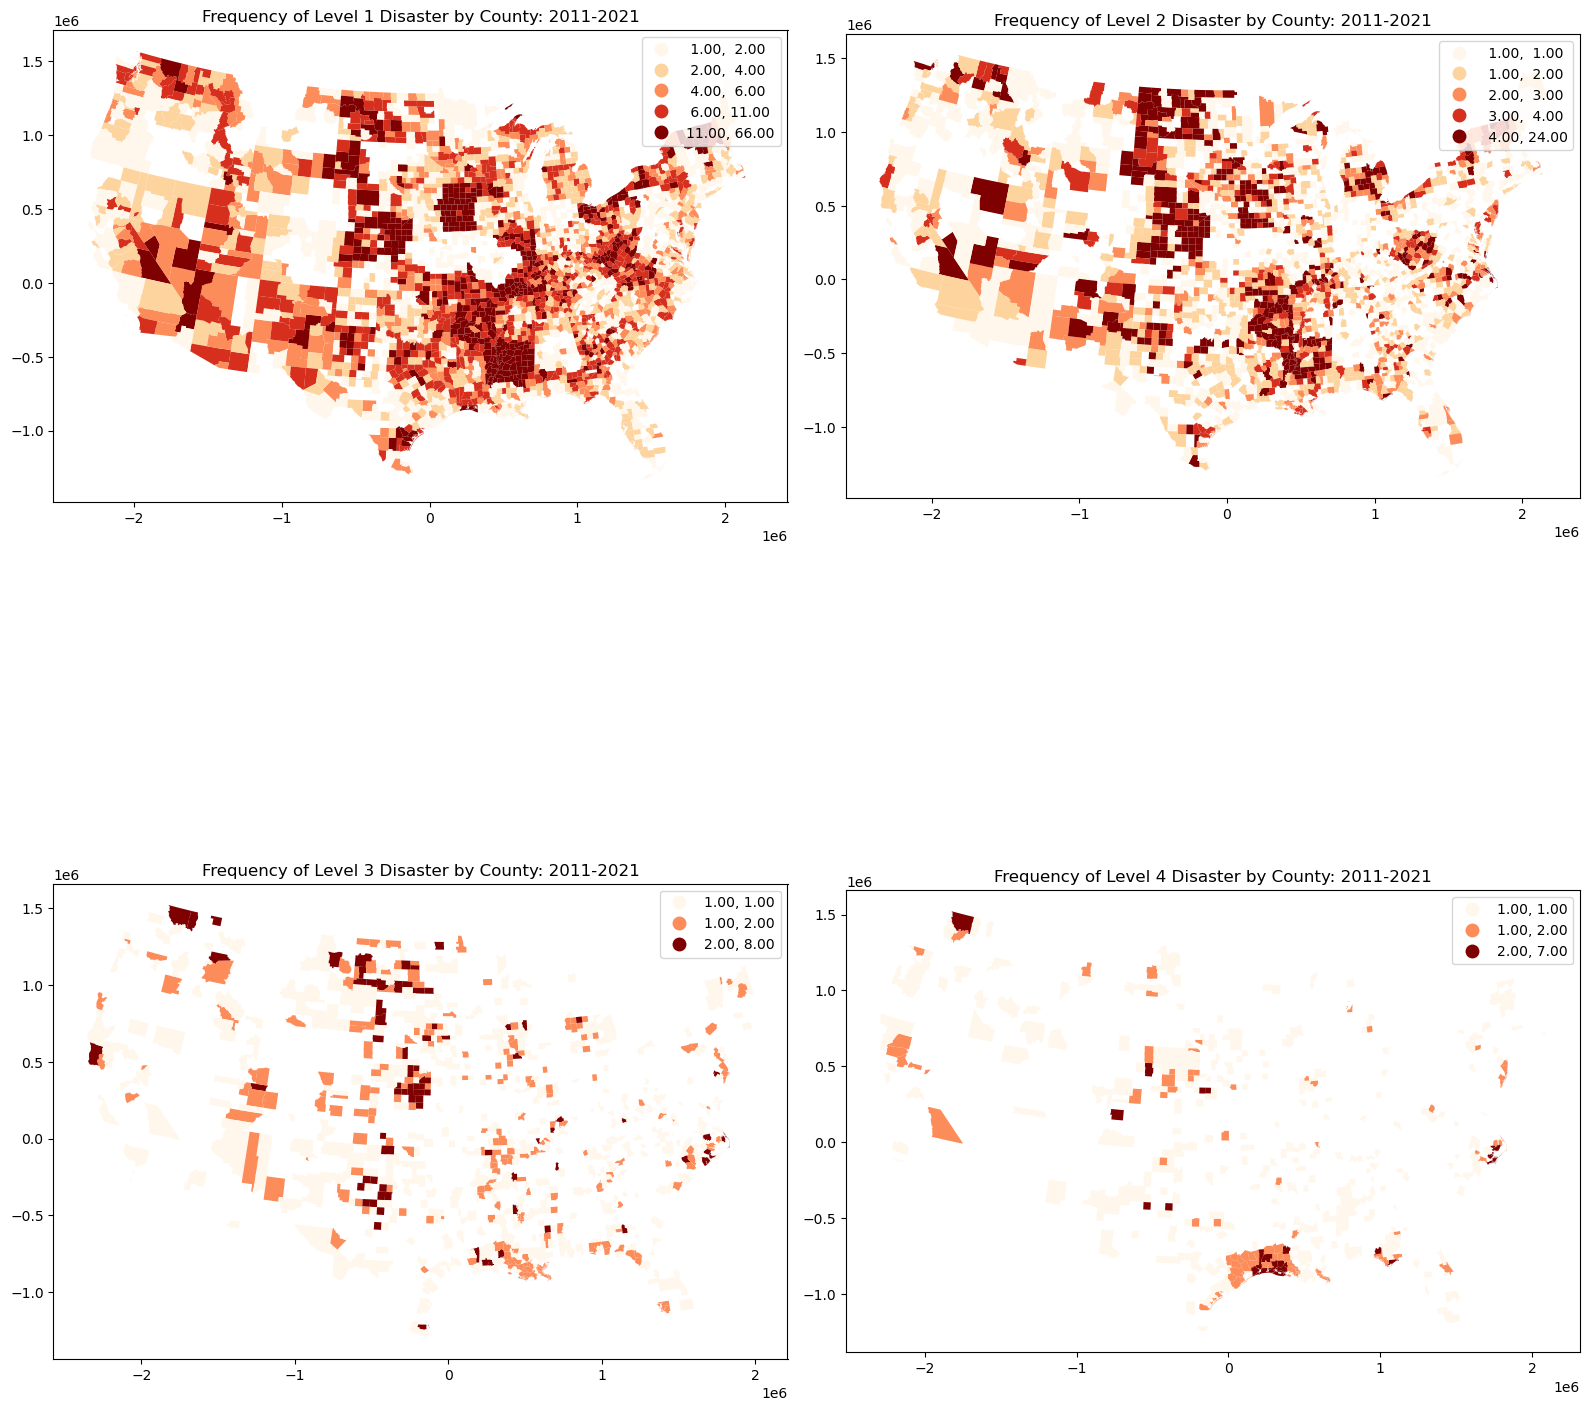

In [294]:
fig, axes = plt.subplots(2,2, figsize=(16, 20))
disaster_0 = SHELDUS_1121_groupcount[SHELDUS_1121_groupcount["perdamageclass"]==0]
disaster_1 = SHELDUS_1121_groupcount[SHELDUS_1121_groupcount["perdamageclass"]==1]
disaster_2 = SHELDUS_1121_groupcount[SHELDUS_1121_groupcount["perdamageclass"]==2]
disaster_3 = SHELDUS_1121_groupcount[SHELDUS_1121_groupcount["perdamageclass"]==3]
disaster_4 = SHELDUS_1121_groupcount[SHELDUS_1121_groupcount["perdamageclass"]==4]
disaster_1.plot(column="count",cmap="OrRd",
                scheme="quantiles",
                ax=axes[0,0],legend=True)
axes[0,0].set_title("Frequency of Level 1 Disaster by County: 2011-2021")
disaster_2.plot(column="count",cmap="OrRd",
                scheme="quantiles",
                ax=axes[0,1],legend=True)
axes[0,1].set_title("Frequency of Level 2 Disaster by County: 2011-2021")
disaster_3.plot(column="count",cmap="OrRd",
                scheme="quantiles",
                ax=axes[1,0],legend=True)
axes[1,0].set_title("Frequency of Level 3 Disaster by County: 2011-2021")
disaster_4.plot(column="count",cmap="OrRd",
                scheme="quantiles",
                ax=axes[1,1],legend=True)
axes[1,1].set_title("Frequency of Level 4 Disaster by County: 2011-2021")
plt.tight_layout()

### Mark: How to create regression between disaster and mobility
https://www.pnas.org/doi/abs/10.1073/pnas.1009510107
https://www.aeaweb.org/articles?id=10.1257/app.3.4.152

### Link different disaster (hard)
### Easier way, relation between population netflow and frequency disaster
move in or move out

dynamic time line
breakdown net population migration in high middle low level

different disaster level,